# Code for fitting Astero and Astro RC data

In [1]:
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_context('notebook')
import pandas as pd
import pystan

import os
import pickle

#from omnitool.literature_values import *

import sys
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_data():
#     sfile = '../Data/MRCxyu18.csv'
    sfile = '../data/KepxDR2/MRCxyu18_wdupes_BC.csv'
    df = pd.read_csv(sfile,index_col=0)
    return df

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))


In [3]:
df = read_data()
df.head(2)
print('Size: '+str(len(df)))

Size: 7725


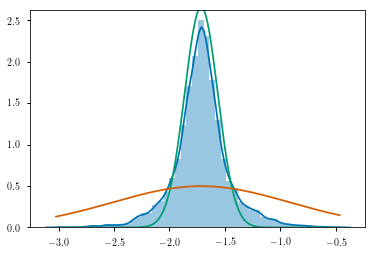

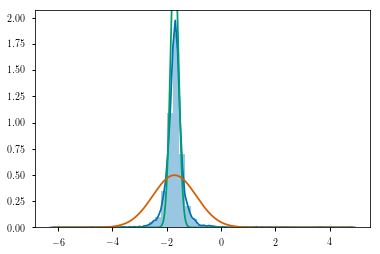

-1.6975076194980592
-1.7142654793172265


In [4]:
'''Step one is figuring out the different distributions we want'''
df.head(2)
aKs = df.ast_MKs.values
pKs = df.phot_MKs.values
stage = df.stage.values
mKs = df.kmag.values
heb = stage == 2

ax = np.linspace(aKs.min(),aKs.max(),1000)
px = np.linspace(pKs.min(),pKs.max(),1000)

afg = normal(ax, np.median(aKs), 0.15)
abg = normal(ax, np.median(aKs), .8)
pfg = normal(px, np.median(aKs), 0.15)
pbg = normal(px, np.median(aKs), .8)

sns.distplot(aKs[heb])
plt.plot(ax,afg)
plt.plot(ax,abg)
plt.show()

sns.distplot(pKs)
plt.plot(px,pfg)
plt.plot(px,pbg)
plt.show()

print(np.median(pKs))
print(np.median(aKs))

## Stan model for asteroseismic values

In [5]:
overwrite = True
asterostan = '''data {
    int<lower = 0> N;
    real M[N];
    real <lower=0> M_err[N];
}

parameters {
    real mu;
    real muo;
    real <lower=0.> sigma;
    real <lower=0.> sigo;
    real <lower=0.,upper=1.> Q;
    real M_true_std[N];
}
transformed parameters{
    real M_true[N];
    real tmuo;
    real<lower=0.> tsigo;

    for (n in 1:N){
        M_true[n] = mu + sigma * M_true_std[n];
    }
    tmuo = muo - mu;
    tsigo = sigo / sigma;
}
model {
    M ~ normal(M_true, M_err); //Measurement uncertainty
    
    //Parameters in true space
    mu ~ normal(-1.71, .1);
    sigma ~ normal(.1, .05);
    Q ~ normal(.95, .01);
    muo ~ normal(-1.71, .01);
    sigo ~ normal(1., .1);


    //Mixture model (in transformed space)
    for (n in 1:N)
        target += log_mix(Q,
            normal_lpdf(M_true_std[n] | 0, 1),
            normal_lpdf(M_true_std[n] | tmuo, tsigo));
}
generated quantities {
    vector[N] post_prob;
    vector[N] bg_pp;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + normal_lpdf(M_true_std[n] | 0, 1);
        ll_bg = log(1-Q) + normal_lpdf(M_true_std[n] | tmuo, tsigo);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
        bg_pp[n] = exp(ll_bg - log_sum_exp(ll_fg, ll_bg));
    }
}

'''
model_path = 'asterostan.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL asterostan_83f1225063849c5c99b2835a21a9fa4c NOW.


Updating Stan model


In [6]:
sel = df[:]
M = sel.ast_MKs.values
M_err = sel.ast_M_err.values
m = sel.kmag
dat = {'N': len(sel),
      'M': M,
      'M_err' : M_err}

init = [{'mu':-1.71,
       'sigma':0.2,
       'Q': 0.95,
       'muo':-1.71,
       'sigo':1.}]

fit = sm.sampling(data=dat, iter=2000, chains=1, init=init)

/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


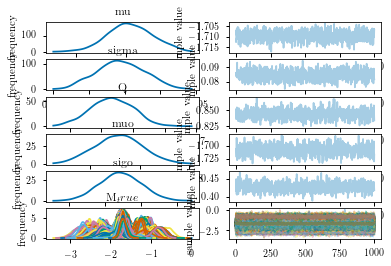

In [7]:
fit.plot(pars=['mu','sigma','Q','muo','sigo','M_true'])
plt.show()

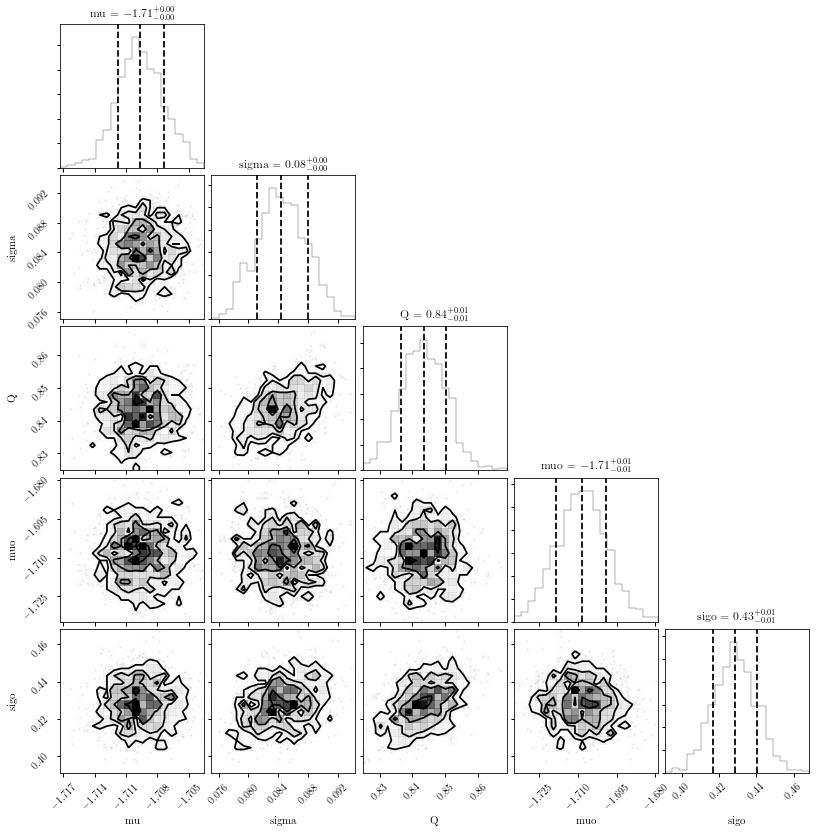

In [8]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['muo'],fit['sigo']])
corner.corner(chain.T,labels=['mu','sigma','Q','muo','sigo'],\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [9]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
muo = np.median(fit['muo'])
sigo = (np.median(fit['sigo']))
Q = np.median(fit['Q'])
tpp = fit['post_prob']
bpp = fit['bg_pp']
post_prob = np.sum(tpp,axis=0)/tpp.shape[0]
bg_pp = np.sum(bpp,axis=0)/bpp.shape[0]

fg = normal(M, mu, sigma)
bg = normal(M, muo, sigo)
L = Q*fg + (1-Q)*bg

Text(0,0.5,u'Units arbitrary')

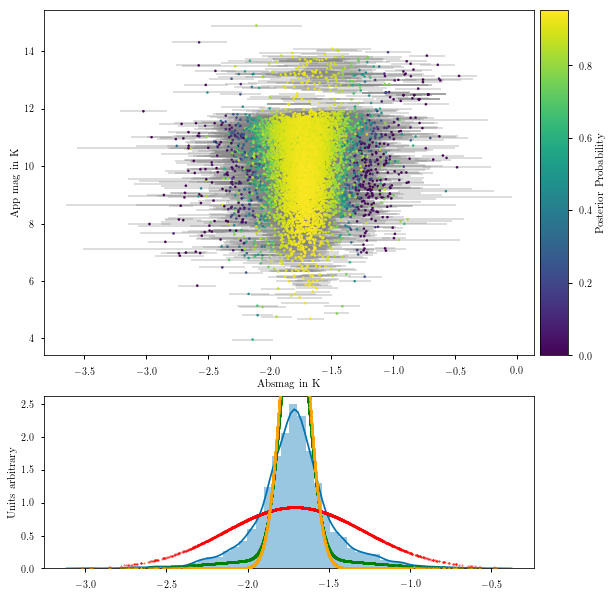

In [10]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])

cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(M,m,s=5,c=post_prob,zorder=1000)
fig.colorbar(c, cax=cax, label='Posterior Probability')
sax.errorbar(M,m,xerr=M_err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(M,ax=xax)

xax.scatter(M,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(M,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(M, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

In [11]:
#Calculate recall vs precision for various Kass+Raftery94 cut off scales
'''Calculate the Kass+Raftery94 lnK values'''
lnK = np.log(post_prob) - np.log(bg_pp)
mask = lnK > 1.

cheb_correct = len(M[mask][sel.stage[mask]==2])
cheb_total = len(M)
identified_total = len(M[mask])
recall = float(cheb_correct)/float(cheb_total)

print('Total stars: '+str(cheb_total))
print('Total IDd as inlier: '+str(cheb_correct))
print('Total rejected: '+str(cheb_total-cheb_correct))
print('This is a '+str((cheb_total-cheb_correct)*100./cheb_total)+'% rejection.')

Total stars: 7725
Total IDd as inlier: 6635
Total rejected: 1090
This is a 14% rejection.


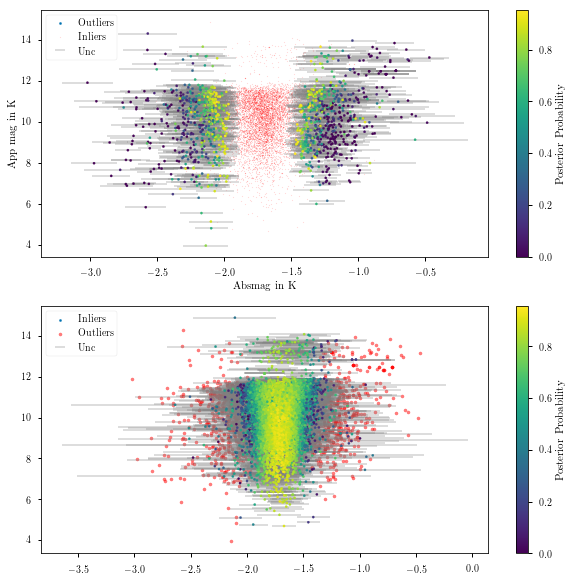

In [12]:
fig, (ax,ax2)  = plt.subplots(2,figsize=(10,10))
ax.scatter(M[~mask],m[~mask],s=5,c=post_prob[~mask],zorder=1000, label='Outliers')
fig.colorbar(c,ax=ax, label='Posterior Probability')
ax.errorbar(M[~mask],m[~mask],xerr=M_err[~mask],c='grey',fmt='none',alpha=.3,zorder=999,label='Unc')
ax.scatter(M[mask],m[mask],s=1,alpha=.1,c='r', label='Inliers')
ax.legend()

ax2.scatter(M[mask],m[mask],s=5,c=post_prob[mask],zorder=1000, label='Inliers')
fig.colorbar(c, ax = ax2, label='Posterior Probability')
ax2.errorbar(M[mask],m[mask],xerr=M_err[mask],c='grey',fmt='none',alpha=.3,zorder=999,label='Unc')
ax2.scatter(M[~mask],m[~mask],s=10,alpha=.5,c='r',label='Outliers')
ax2.legend()

ax.set_xlabel('Absmag in K')
ax.set_ylabel('App mag in K')
plt.show()

What the above plot indicates is that inlier stars are defined by uncertainty more than anything else, and that allt he outlier stars have uncertainties that end near a similar limit, whereas the inlier stars can be more spread out, so long as their uncertainties have a chance at placing them at the overdensity.

In [13]:
s = fit.summary()

[0.99922361 0.99899973 1.05329269 ... 0.99972687 1.00357528 1.04486801]
Total number of Rhats: 30910
Total number of Rhats with the NaN values removed: 30772


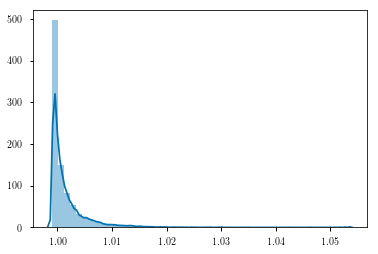

In [14]:
print(s['summary'][:,-1])
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()

In [15]:
sys.exit()

SystemExit: 

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Stan model for astrometric values

#### Gather the relevant data

In [ ]:
from omnitool import spyglass
sg = spyglass()
sg.pass_position(df.ra, df.dec, frame='icrs')
sg.pass_distance(df.r_est, err=df.r_err)
sg.band = 'Ks'
df['Ak'] = sg.get_Aband()

In [ ]:
overwrite=True
stanmod = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower = 0> N;
    real mi[N];
    real<lower=0> mi_err[N];
    real oo[N];
    real<lower=0> oo_err[N];
    real<lower=0> Al[N];
}
parameters {
    //Hyperparameters
    real L;
    real murc;
    real muo;
    real <lower=0.> sigrc;
    real <lower=0.> sigo; //Line 20
    real <lower=0.,upper=1.> Q;
    
    //Latent Parameters
    real<lower = 0.> Ai[N];
    real<lower = 1.> ri[N]; 
    real Mi[N];
}
transformed parameters {
    real oo_true[N];
    real mi_pred[N];
    
    for(n in 1:N){   
        oo_true[n] = (1000./ri[n]);   //oo_true is evaluated in ri space
        mi_pred[n] = Mi[n] + 5*log10(ri[n]) - 5 + Ai[n];   //mi_pred is evaluated in other spaces
    }
}
model {  
    //Hyperparameters
    L ~ uniform(100, 4000); //Line 40
    murc ~ uniform(-2., -1.);
    muo ~ uniform(-2., -1.);
    sigrc ~ uniform(0.01, .2);
    sigo ~ uniform(.2, 5.);
    Q ~ uniform(0., 1.);
    
    //Latent parameters
    Ai ~ normal(Al, 0.05);
    for (n in 1:N){
        ri[n] ~ bailerjones(L);
        target += log_mix(Q,
            normal_lpdf(Mi[n] | murc, sigrc), //Line 51
            normal_lpdf(Mi[n] | muo, sigo));
    } 

    //Observables
    oo ~ normal(oo_true, oo_err);
    mi ~ normal(mi_pred, mi_err);
    
    //Equation
    for (n in 1:N){
        target += oo[n] * mi[n];
    }
}
'''
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = stanmod, model_name='astrostan')
    with open('../data/stanmodels/astrostan.pkl', 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile('../data/stanmodels/astrostan.pkl'):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open('../data/stanmodels/astrostan.pkl', 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = stanmod, model_name='astrostan')
        with open('../data/stanmodels/astrostan.pkl', 'wb') as f:
            pickle.dump(sm, f)
print('Done')

Lets just check whether anything I feed in is 0

In [ ]:
sel = df[:500]
mi = sel.kmag.values
mi_err = np.ones(len(sel))*0.1
np.where(mi_err == 0.)

#### Run the model

In [ ]:
sel = df[:500]
mi = sel.kmag.values
mi_err = np.ones(len(sel))*0.1
oo = sel.parallax.values
oo_err = sel.parallax_error.values
Al = sel.Ak.values
dat = {'N': len(sel),
       'mi': mi,
       'mi_err' : mi_err,
       'oo': oo,
       'oo_err': oo_err,
       'Al': Al,
      }

fit = sm.sampling(data=dat, iter=2000, chains=1)

In [ ]:
import corner
trace = fit.extract()
chain = np.array([trace['murc'],trace['sigrc'],trace['Q'],trace['sigo'],trace['L']])
corner.corner(chain.T,labels=['murc','sigrc','Q','sigo','L'])
plt.show()

In [ ]:
fit.plot(pars=['murc','sigrc','Q','sigo','L','oo_true'])
plt.show()

In [ ]:
murc = np.median(trace['murc'])
sigrc = np.median(trace['sigrc'])
sigo = np.median(trace['sigo'])
Q = np.median(trace['Q'])
tpp = trace['post_prob']
post_prob = np.sum(tpp,axis=0)/tpp.shape[0]

fg = normal(sel.phot_MKs, murc, sigrc)
bg = normal(sel.phot_Mks, murc, sigo)
L = Q*fg + (1-Q)*bg

In [ ]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])

cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(sel.ast_MKs.values,sel.kmag.values,s=1,c=post_prob,zorder=1000)
fig.colorbar(c, cax=cax, label='Posterior Probability')
sax.errorbar(sel.ast_MKs.values,sel.kmag.values,xerr=sel.ast_M_err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(sel.ast_MKs.values,ax=xax)

xax.scatter(sel.ast_MKs.values,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(sel.ast_MKs.values,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(sel.ast_MKs.values, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

## Other useful code

In [ ]:
sns.distplot(Ks[heb])
plt.scatter(Ks,fg,s=3)
sns.distplot(Ks[~heb])
plt.scatter(Ks,bg,s=3)
plt.show()

sns.distplot(Ks)
plt.scatter(Ks,L,s=3)
plt.show()

In [ ]:
sys.exit()


In [ ]:
#Calculate recall vs precision for various Kass+Raftery94 cut off scales
'''Calculate the Kass+Raftery94 lnK values'''
lnK = np.log(post_prob) - np.log(bg_pp)

recall, precision = [], []
for lim in np.linspace(lnK.min(),lnK.max(),1000):
    mask = lnK > lim
    cheb_correct = len(Ks[mask][stage[mask]==2])
    cheb_total = len(Ks[stage==2])
    identified_total = len(Ks[mask])
    recall.append(float(cheb_correct)/float(cheb_total))
    try:
        precision.append(float(cheb_correct)/float(identified_total))
    except:
        precision.append(0.)
        
fig, ax = plt.subplots()
col = ax.scatter(recall, precision, c=np.linspace(lnK.min(),lnK.max(),1000),vmin=0.)
ax.axhline(0.9,c='r',label='0.9 precision')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
ax.set_axisbelow(True)
fig.colorbar(col, label='lnK cut-off point',extend='min')
plt.show()        


In [ ]:
import barbershop
%pylab inline
barber = barbershop.open(df,'ast_MKs','M')
barber.add_client('stage')
barber.add_client('logg')
barber.add_client('M')
barber.histograms_on(x=True, y=True)
barber.show_mirror()

In [ ]:
list(df)
import os
os.path.isfile('../data/KepxDR2/MRCxyu18.csv')